In [53]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# 基于Crossformer的时间序列预测

## 多变量多步预测

### 数据准备

In [14]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [15]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [16]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [17]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [18]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [19]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [34]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]
    
    
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, padding, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = nn.ReplicationPad1d((0, padding))

        # Backbone, Input encoding: projection of feature vectors onto a d-dim vector space
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)

        # Positional embedding
        self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x), n_vars
    
    
class TwoStageAttentionLayer(nn.Module):
    '''
    The Two Stage Attention (TSA) Layer
    input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
    '''

    def __init__(self, seg_num, factor, d_model, n_heads, output_attention, d_ff=None, dropout=0.1):
        super(TwoStageAttentionLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.time_attention = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                           output_attention=output_attention), d_model, n_heads)
        self.dim_sender = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                       output_attention=output_attention), d_model, n_heads)
        self.dim_receiver = AttentionLayer(FullAttention(False, factor, attention_dropout=dropout,
                                                         output_attention=output_attention), d_model, n_heads)
        self.router = nn.Parameter(torch.randn(seg_num, factor, d_model))

        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
                                  nn.GELU(),
                                  nn.Linear(d_ff, d_model))

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # Cross Time Stage: Directly apply MSA to each dimension
        batch = x.shape[0]
        time_in = rearrange(x, 'b ts_d seg_num d_model -> (b ts_d) seg_num d_model')
        time_enc, attn = self.time_attention(
            time_in, time_in, time_in, attn_mask=None, tau=None, delta=None
        )
        dim_in = time_in + self.dropout(time_enc)
        dim_in = self.norm1(dim_in)
        dim_in = dim_in + self.dropout(self.MLP1(dim_in))
        dim_in = self.norm2(dim_in)

        # Cross Dimension Stage: use a small set of learnable vectors to aggregate and distribute messages to build the D-to-D connection
        dim_send = rearrange(dim_in, '(b ts_d) seg_num d_model -> (b seg_num) ts_d d_model', b=batch)
        batch_router = repeat(self.router, 'seg_num factor d_model -> (repeat seg_num) factor d_model', repeat=batch)
        dim_buffer, attn = self.dim_sender(batch_router, dim_send, dim_send, attn_mask=None, tau=None, delta=None)
        dim_receive, attn = self.dim_receiver(dim_send, dim_buffer, dim_buffer, attn_mask=None, tau=None, delta=None)
        dim_enc = dim_send + self.dropout(dim_receive)
        dim_enc = self.norm3(dim_enc)
        dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
        dim_enc = self.norm4(dim_enc)

        final_out = rearrange(dim_enc, '(b seg_num) ts_d d_model -> b ts_d seg_num d_model', b=batch)

        return final_out

    
class SegMerging(nn.Module):
    def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
        super().__init__()
        self.d_model = d_model
        self.win_size = win_size
        self.linear_trans = nn.Linear(win_size * d_model, d_model)
        self.norm = norm_layer(win_size * d_model)

    def forward(self, x):
        batch_size, ts_d, seg_num, d_model = x.shape
        pad_num = seg_num % self.win_size
        if pad_num != 0:
            pad_num = self.win_size - pad_num
            x = torch.cat((x, x[:, :, -pad_num:, :]), dim=-2)

        seg_to_merge = []
        for i in range(self.win_size):
            seg_to_merge.append(x[:, :, i::self.win_size, :])
        x = torch.cat(seg_to_merge, -1)

        x = self.norm(x)
        x = self.linear_trans(x)

        return x


class scale_block(nn.Module):
    def __init__(self, win_size, d_model, n_heads, d_ff, depth, dropout, output_attention, 
                 seg_num=10, factor=10):
        super(scale_block, self).__init__()

        if win_size > 1:
            self.merge_layer = SegMerging(d_model, win_size, nn.LayerNorm)
        else:
            self.merge_layer = None

        self.encode_layers = nn.ModuleList()

        for i in range(depth):
            self.encode_layers.append(TwoStageAttentionLayer(seg_num, factor, d_model, n_heads, output_attention, 
                                                             d_ff, dropout))

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        _, ts_dim, _, _ = x.shape

        if self.merge_layer is not None:
            x = self.merge_layer(x)

        for layer in self.encode_layers:
            x = layer(x)

        return x, None


class Encoder(nn.Module):
    def __init__(self, attn_layers):
        super(Encoder, self).__init__()
        self.encode_blocks = nn.ModuleList(attn_layers)

    def forward(self, x):
        encode_x = []
        encode_x.append(x)

        for block in self.encode_blocks:
            x, attns = block(x)
            encode_x.append(x)

        return encode_x, None


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, seg_len, d_model, d_ff=None, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_model),
                                  nn.GELU(),
                                  nn.Linear(d_model, d_model))
        self.linear_pred = nn.Linear(d_model, seg_len)

    def forward(self, x, cross):
        batch = x.shape[0]
        x = self.self_attention(x)
        x = rearrange(x, 'b ts_d out_seg_num d_model -> (b ts_d) out_seg_num d_model')

        cross = rearrange(cross, 'b ts_d in_seg_num d_model -> (b ts_d) in_seg_num d_model')
        tmp, attn = self.cross_attention(x, cross, cross, None, None, None,)
        x = x + self.dropout(tmp)
        y = x = self.norm1(x)
        y = self.MLP1(y)
        dec_output = self.norm2(x + y)

        dec_output = rearrange(dec_output, '(b ts_d) seg_dec_num d_model -> b ts_d seg_dec_num d_model', b=batch)
        layer_predict = self.linear_pred(dec_output)
        layer_predict = rearrange(layer_predict, 'b out_d seg_num seg_len -> b (out_d seg_num) seg_len')

        return dec_output, layer_predict


class Decoder(nn.Module):
    def __init__(self, layers):
        super(Decoder, self).__init__()
        self.decode_layers = nn.ModuleList(layers)


    def forward(self, x, cross):
        final_predict = None
        i = 0

        ts_d = x.shape[1]
        for layer in self.decode_layers:
            cross_enc = cross[i]
            x, layer_predict = layer(x, cross_enc)
            if final_predict is None:
                final_predict = layer_predict
            else:
                final_predict = final_predict + layer_predict
            i += 1

        final_predict = rearrange(final_predict, 'b (out_d seg_num) seg_len -> b (seg_num seg_len) out_d', out_d=ts_d)

        return final_predict

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
# Crossformer模型
class Crossformer(nn.Module):
    def __init__(self, enc_in, seq_len, pred_len, e_layers, d_layers, d_model, 
                 output_attention, n_heads, d_ff, dropout, factor):
        super(Crossformer, self).__init__()
        self.enc_in = enc_in
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.seg_len = 12
        self.win_size = 2

        # The padding operation to handle invisible sgemnet length
        self.pad_in_len = math.ceil(1.0 * seq_len / self.seg_len) * self.seg_len
        self.pad_out_len = math.ceil(1.0 * pred_len / self.seg_len) * self.seg_len
        self.in_seg_num = self.pad_in_len // self.seg_len
        self.out_seg_num = math.ceil(self.in_seg_num / (self.win_size ** (e_layers - 1)))
        self.head_nf = d_model * self.out_seg_num

        # Embedding
        self.enc_value_embedding = PatchEmbedding(d_model, self.seg_len, self.seg_len, self.pad_in_len - seq_len, 0)
        self.enc_pos_embedding = nn.Parameter(
            torch.randn(1, enc_in, self.in_seg_num, d_model))
        self.pre_norm = nn.LayerNorm(d_model)

        # Encoder
        self.encoder = Encoder(
            [
                scale_block(1 if l is 0 else self.win_size, d_model, n_heads, d_ff, 1, dropout, output_attention, 
                            self.in_seg_num if l is 0 else math.ceil(self.in_seg_num / self.win_size ** l), factor
                            ) for l in range(e_layers)
            ]
        )
        # Decoder
        self.dec_pos_embedding = nn.Parameter(
            torch.randn(1, enc_in, (self.pad_out_len // self.seg_len), d_model))

        self.decoder = Decoder(
            [
                DecoderLayer(
                    TwoStageAttentionLayer((self.pad_out_len // self.seg_len), factor, d_model, n_heads, output_attention,
                                           d_ff, dropout),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    self.seg_len,
                    d_model,
                    d_ff,
                    dropout=dropout,
                    # activation=configs.activation,
                )
                for l in range(d_layers + 1)
            ],
        )


    def forward(self, x_enc):
        # embedding
        x_enc, n_vars = self.enc_value_embedding(x_enc.permute(0, 2, 1))
        x_enc = rearrange(x_enc, '(b d) seg_num d_model -> b d seg_num d_model', d = n_vars)
        x_enc += self.enc_pos_embedding
        x_enc = self.pre_norm(x_enc)
        enc_out, attns = self.encoder(x_enc)

        dec_in = repeat(self.dec_pos_embedding, 'b ts_d l d -> (repeat b) ts_d l d', repeat=x_enc.shape[0])
        dec_out = self.decoder(dec_in, enc_out)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [35]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:31<09:58, 31.53s/it]

Epoch [1/20], Training Loss: 0.0158, Validation Loss: 0.0110
Validation loss decreased (inf --> 0.011013).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:01<09:13, 30.76s/it]

Epoch [2/20], Training Loss: 0.0057, Validation Loss: 0.0074
Validation loss decreased (0.011013 --> 0.007376).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:32<08:39, 30.54s/it]

Epoch [3/20], Training Loss: 0.0042, Validation Loss: 0.0044
Validation loss decreased (0.007376 --> 0.004405).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:02<08:09, 30.61s/it]

Epoch [4/20], Training Loss: 0.0033, Validation Loss: 0.0037
Validation loss decreased (0.004405 --> 0.003723).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:33<07:37, 30.51s/it]

Epoch [5/20], Training Loss: 0.0028, Validation Loss: 0.0042
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [03:04<07:10, 30.74s/it]

Epoch [6/20], Training Loss: 0.0025, Validation Loss: 0.0033
Validation loss decreased (0.003723 --> 0.003262).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [03:36<06:44, 31.15s/it]

Epoch [7/20], Training Loss: 0.0023, Validation Loss: 0.0044
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [04:07<06:13, 31.15s/it]

Epoch [8/20], Training Loss: 0.0021, Validation Loss: 0.0032
Validation loss decreased (0.003262 --> 0.003217).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [04:38<05:42, 31.12s/it]

Epoch [9/20], Training Loss: 0.0019, Validation Loss: 0.0033
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [05:09<05:12, 31.20s/it]

Epoch [10/20], Training Loss: 0.0018, Validation Loss: 0.0031
Validation loss decreased (0.003217 --> 0.003125).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [05:41<04:41, 31.30s/it]

Epoch [11/20], Training Loss: 0.0017, Validation Loss: 0.0037
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:14<04:14, 31.79s/it]

Epoch [12/20], Training Loss: 0.0016, Validation Loss: 0.0044
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [06:46<03:42, 31.81s/it]

Epoch [13/20], Training Loss: 0.0015, Validation Loss: 0.0031
Validation loss decreased (0.003125 --> 0.003071).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [07:16<03:08, 31.49s/it]

Epoch [14/20], Training Loss: 0.0014, Validation Loss: 0.0037
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [07:48<02:37, 31.55s/it]

Epoch [15/20], Training Loss: 0.0014, Validation Loss: 0.0033
EarlyStopping counter: 2 out of 7
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [08:19<02:05, 31.49s/it]

Epoch [16/20], Training Loss: 0.0013, Validation Loss: 0.0029
Validation loss decreased (0.003071 --> 0.002893).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [08:51<01:34, 31.53s/it]

Epoch [17/20], Training Loss: 0.0013, Validation Loss: 0.0032
EarlyStopping counter: 1 out of 7
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [09:24<01:03, 31.86s/it]

Epoch [18/20], Training Loss: 0.0013, Validation Loss: 0.0031
EarlyStopping counter: 2 out of 7
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [09:57<00:32, 32.37s/it]

Epoch [19/20], Training Loss: 0.0012, Validation Loss: 0.0031
EarlyStopping counter: 3 out of 7
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:29<00:00, 31.50s/it]

Epoch [20/20], Training Loss: 0.0012, Validation Loss: 0.0030
EarlyStopping counter: 4 out of 7
Updating learning rate to 0.0


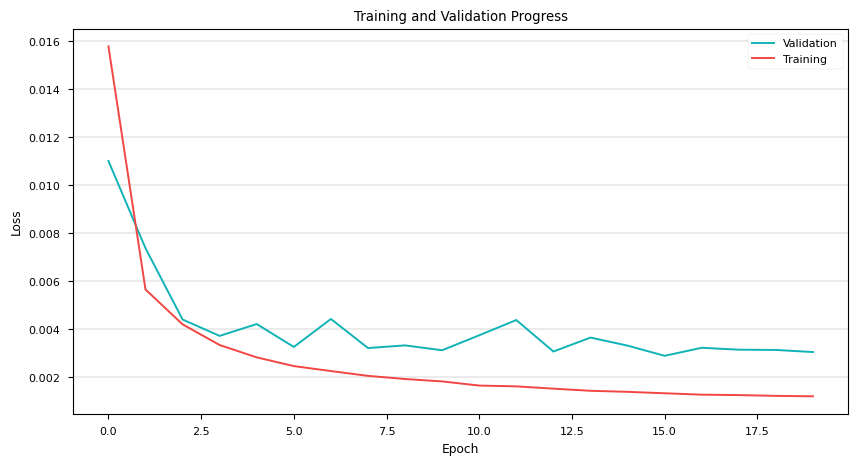

In [37]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load'],
        "features": 'MS'
    },
    "train_args": {
        "model_name": Crossformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 2, 
        'seq_len': 2 * 3,
        'pred_len': 3,
        'output_attention': False,
        'd_model': 32,
        'n_heads': 8,
        'd_ff': 32,
        'dropout': 0.1,
        'e_layers': 1,
        'd_layers': 1,
        'factor': 3
    },
}
model = train(**params3)

# 基于ETSformer的时间序列预测

## 多变量多步预测

### 数据准备

In [63]:
# 读取数据
def get_dataset(path, time_col=None):
    data = pd.read_csv(path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [ ]:
path = "../data/energy.csv"
ts_data = get_dataset(path, time_col='time')
ts_data

In [ ]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [64]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [65]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [66]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 1]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 1]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型定义

In [70]:
# 编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# 编码器和解码器
class Transform:
    def __init__(self, sigma):
        self.sigma = sigma

    @torch.no_grad()
    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        return x + (torch.randn(x.shape).to(x.device) * self.sigma)

    def scale(self, x):
        return x * (torch.randn(x.size(-1)).to(x.device) * self.sigma + 1)

    def shift(self, x):
        return x + (torch.randn(x.size(-1)).to(x.device) * self.sigma)


def conv1d_fft(f, g, dim=-1):
    N = f.size(dim)
    M = g.size(dim)

    fast_len = next_fast_len(N + M - 1)

    F_f = fft.rfft(f, fast_len, dim=dim)
    F_g = fft.rfft(g, fast_len, dim=dim)

    F_fg = F_f * F_g.conj()
    out = fft.irfft(F_fg, fast_len, dim=dim)
    out = out.roll((-1,), dims=(dim,))
    idx = torch.as_tensor(range(fast_len - N, fast_len)).to(out.device)
    out = out.index_select(dim, idx)

    return out


class ExponentialSmoothing(nn.Module):

    def __init__(self, dim, nhead, dropout=0.1, aux=False):
        super().__init__()
        self._smoothing_weight = nn.Parameter(torch.randn(nhead, 1))
        self.v0 = nn.Parameter(torch.randn(1, 1, nhead, dim))
        self.dropout = nn.Dropout(dropout)
        if aux:
            self.aux_dropout = nn.Dropout(dropout)

    def forward(self, values, aux_values=None):
        b, t, h, d = values.shape

        init_weight, weight = self.get_exponential_weight(t)
        output = conv1d_fft(self.dropout(values), weight, dim=1)
        output = init_weight * self.v0 + output

        if aux_values is not None:
            aux_weight = weight / (1 - self.weight) * self.weight
            aux_output = conv1d_fft(self.aux_dropout(aux_values), aux_weight)
            output = output + aux_output

        return output

    def get_exponential_weight(self, T):
        # Generate array [0, 1, ..., T-1]
        powers = torch.arange(T, dtype=torch.float, device=self.weight.device)

        # (1 - \alpha) * \alpha^t, for all t = T-1, T-2, ..., 0]
        weight = (1 - self.weight) * (self.weight ** torch.flip(powers, dims=(0,)))

        # \alpha^t for all t = 1, 2, ..., T
        init_weight = self.weight ** (powers + 1)

        return rearrange(init_weight, 'h t -> 1 t h 1'), \
               rearrange(weight, 'h t -> 1 t h 1')

    @property
    def weight(self):
        return torch.sigmoid(self._smoothing_weight)


class Feedforward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1, activation='sigmoid'):
        # Implementation of Feedforward model
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward, bias=False)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = getattr(F, activation)

    def forward(self, x):
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)


class GrowthLayer(nn.Module):

    def __init__(self, d_model, nhead, d_head=None, dropout=0.1):
        super().__init__()
        self.d_head = d_head or (d_model // nhead)
        self.d_model = d_model
        self.nhead = nhead

        self.z0 = nn.Parameter(torch.randn(self.nhead, self.d_head))
        self.in_proj = nn.Linear(self.d_model, self.d_head * self.nhead)
        self.es = ExponentialSmoothing(self.d_head, self.nhead, dropout=dropout)
        self.out_proj = nn.Linear(self.d_head * self.nhead, self.d_model)

        assert self.d_head * self.nhead == self.d_model, "d_model must be divisible by nhead"

    def forward(self, inputs):
        """
        :param inputs: shape: (batch, seq_len, dim)
        :return: shape: (batch, seq_len, dim)
        """
        b, t, d = inputs.shape
        values = self.in_proj(inputs).view(b, t, self.nhead, -1)
        values = torch.cat([repeat(self.z0, 'h d -> b 1 h d', b=b), values], dim=1)
        values = values[:, 1:] - values[:, :-1]
        out = self.es(values)
        out = torch.cat([repeat(self.es.v0, '1 1 h d -> b 1 h d', b=b), out], dim=1)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return self.out_proj(out)


class FourierLayer(nn.Module):

    def __init__(self, d_model, pred_len, k=None, low_freq=1):
        super().__init__()
        self.d_model = d_model
        self.pred_len = pred_len
        self.k = k
        self.low_freq = low_freq

    def forward(self, x):
        """x: (b, t, d)"""
        b, t, d = x.shape
        x_freq = fft.rfft(x, dim=1)

        if t % 2 == 0:
            x_freq = x_freq[:, self.low_freq:-1]
            f = fft.rfftfreq(t)[self.low_freq:-1]
        else:
            x_freq = x_freq[:, self.low_freq:]
            f = fft.rfftfreq(t)[self.low_freq:]

        x_freq, index_tuple = self.topk_freq(x_freq)
        f = repeat(f, 'f -> b f d', b=x_freq.size(0), d=x_freq.size(2))
        f = rearrange(f[index_tuple], 'b f d -> b f () d').to(x_freq.device)

        return self.extrapolate(x_freq, f, t)

    def extrapolate(self, x_freq, f, t):
        x_freq = torch.cat([x_freq, x_freq.conj()], dim=1)
        f = torch.cat([f, -f], dim=1)
        t_val = rearrange(torch.arange(t + self.pred_len, dtype=torch.float),
                          't -> () () t ()').to(x_freq.device)

        amp = rearrange(x_freq.abs() / t, 'b f d -> b f () d')
        phase = rearrange(x_freq.angle(), 'b f d -> b f () d')

        x_time = amp * torch.cos(2 * math.pi * f * t_val + phase)

        return reduce(x_time, 'b f t d -> b t d', 'sum')

    def topk_freq(self, x_freq):
        values, indices = torch.topk(x_freq.abs(), self.k, dim=1, largest=True, sorted=True)
        mesh_a, mesh_b = torch.meshgrid(torch.arange(x_freq.size(0)), torch.arange(x_freq.size(2)))
        index_tuple = (mesh_a.unsqueeze(1), indices, mesh_b.unsqueeze(1))
        x_freq = x_freq[index_tuple]

        return x_freq, index_tuple


class LevelLayer(nn.Module):

    def __init__(self, d_model, c_out, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.c_out = c_out

        self.es = ExponentialSmoothing(1, self.c_out, dropout=dropout, aux=True)
        self.growth_pred = nn.Linear(self.d_model, self.c_out)
        self.season_pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, level, growth, season):
        b, t, _ = level.shape
        growth = self.growth_pred(growth).view(b, t, self.c_out, 1)
        season = self.season_pred(season).view(b, t, self.c_out, 1)
        growth = growth.view(b, t, self.c_out, 1)
        season = season.view(b, t, self.c_out, 1)
        level = level.view(b, t, self.c_out, 1)
        out = self.es(level - season, aux_values=growth)
        out = rearrange(out, 'b t h d -> b t (h d)')
        return out


class EncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, seq_len, pred_len, k, dim_feedforward=None, dropout=0.1,
                 activation='sigmoid', layer_norm_eps=1e-5):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.seq_len = seq_len
        self.pred_len = pred_len
        dim_feedforward = dim_feedforward or 4 * d_model
        self.dim_feedforward = dim_feedforward

        self.growth_layer = GrowthLayer(d_model, nhead, dropout=dropout)
        self.seasonal_layer = FourierLayer(d_model, pred_len, k=k)
        self.level_layer = LevelLayer(d_model, c_out, dropout=dropout)

        # Implementation of Feedforward model
        self.ff = Feedforward(d_model, dim_feedforward, dropout=dropout, activation=activation)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, res, level, attn_mask=None):
        season = self._season_block(res)
        res = res - season[:, :-self.pred_len]
        growth = self._growth_block(res)
        res = self.norm1(res - growth[:, 1:])
        res = self.norm2(res + self.ff(res))

        level = self.level_layer(level, growth[:, :-1], season[:, :-self.pred_len])
        return res, level, growth, season

    def _growth_block(self, x):
        x = self.growth_layer(x)
        return self.dropout1(x)

    def _season_block(self, x):
        x = self.seasonal_layer(x)
        return self.dropout2(x)


class Encoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, res, level, attn_mask=None):
        growths = []
        seasons = []
        for layer in self.layers:
            res, level, growth, season = layer(res, level, attn_mask=None)
            growths.append(growth)
            seasons.append(season)

        return level, growths, seasons


class DampingLayer(nn.Module):

    def __init__(self, pred_len, nhead, dropout=0.1):
        super().__init__()
        self.pred_len = pred_len
        self.nhead = nhead
        self._damping_factor = nn.Parameter(torch.randn(1, nhead))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = repeat(x, 'b 1 d -> b t d', t=self.pred_len)
        b, t, d = x.shape

        powers = torch.arange(self.pred_len).to(self._damping_factor.device) + 1
        powers = powers.view(self.pred_len, 1)
        damping_factors = self.damping_factor ** powers
        damping_factors = damping_factors.cumsum(dim=0)
        x = x.view(b, t, self.nhead, -1)
        x = self.dropout(x) * damping_factors.unsqueeze(-1)
        return x.view(b, t, d)

    @property
    def damping_factor(self):
        return torch.sigmoid(self._damping_factor)


class DecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, c_out, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.c_out = c_out
        self.pred_len = pred_len

        self.growth_damping = DampingLayer(pred_len, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, growth, season):
        growth_horizon = self.growth_damping(growth[:, -1:])
        growth_horizon = self.dropout1(growth_horizon)

        seasonal_horizon = season[:, -self.pred_len:]
        return growth_horizon, seasonal_horizon


class Decoder(nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.d_model = layers[0].d_model
        self.c_out = layers[0].c_out
        self.pred_len = layers[0].pred_len
        self.nhead = layers[0].nhead

        self.layers = nn.ModuleList(layers)
        self.pred = nn.Linear(self.d_model, self.c_out)

    def forward(self, growths, seasons):
        growth_repr = []
        season_repr = []

        for idx, layer in enumerate(self.layers):
            growth_horizon, season_horizon = layer(growths[idx], seasons[idx])
            growth_repr.append(growth_horizon)
            season_repr.append(season_horizon)
        growth_repr = sum(growth_repr)
        season_repr = sum(season_repr)
        return self.pred(growth_repr), self.pred(season_repr)

    
# ETSformer模型
class ETSformer(nn.Module):
    def __init__(self, seq_len, pred_len, e_layers, d_layers, enc_in, d_model, 
                 dropout, n_heads, top_k, d_ff, c_out):
        super(ETSformer, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        assert e_layers == d_layers, "Encoder and decoder layers must be equal"

        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    d_model, n_heads, enc_in, seq_len, pred_len, top_k,
                    dim_feedforward=d_ff,
                    dropout=dropout,
                    activation='relu',
                ) for _ in range(e_layers)
            ]
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    d_model, n_heads, c_out, pred_len,
                    dropout=dropout,
                ) for _ in range(d_layers)
            ],
        )
        self.transform = Transform(sigma=0.2)

    def forward(self, x_enc, x_mark_enc=None):
        with torch.no_grad():
            if self.training:
                x_enc = self.transform.transform(x_enc)
#         x_enc = self.transform.transform(x_enc)
        res = self.enc_embedding(x_enc, x_mark_enc)
        level, growths, seasons = self.encoder(res, x_enc, attn_mask=None)

        growth, season = self.decoder(growths, seasons)
        dec_out = level[:, -1:] + growth + season
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [71]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            f_dim = col_dict[target]
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            if features == 'MS':
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                outputs = outputs[:, :, f_dim:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                if features == 'MS':
                    val_outputs = val_outputs[:, :, f_dim: f_dim+1] 
                else:
                    val_outputs = val_outputs[:, :, f_dim:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [72]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load'],
        "target": ['load'],
        "features": 'S'
    },
    "train_args": {
        "model_name": ETSformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "lradj": 'cosine',
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'enc_in': 1, 
        'seq_len': 2 * 3,
        'pred_len': 3,
        'top_k': 2,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 128,
        'dropout': 0.1,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 1
    },
}
model = train(**params3)

  5%|████▏                                                                              | 1/20 [00:31<09:59, 31.54s/it]

Epoch [1/20], Training Loss: 0.0424, Validation Loss: 0.0397
Validation loss decreased (inf --> 0.039718).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:23<13:08, 43.81s/it]

Epoch [2/20], Training Loss: 0.0312, Validation Loss: 0.0315
Validation loss decreased (0.039718 --> 0.031464).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [02:28<15:04, 53.19s/it]

Epoch [3/20], Training Loss: 0.0300, Validation Loss: 0.0356
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0009455032620941839


 15%|████████████▍                                                                      | 3/20 [02:48<15:54, 56.16s/it]


KeyboardInterrupt: 